# Insurance Losses - dataset analysis
---
This dataset represents the losses by policy_number of an insurance car company. An exploratory analysis will be taken in order to understand what kind of insights is possible to harvest from this dataset.


In [0]:
# importing the core lib
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# downloading the csv file from the drive
%%sh
wget --quiet --output-document insurance_losses.csv 'https://drive.google.com/uc?authuser=0&id=1X-jvKn6mwxmyyqFidvC2eU3GjAQyFKvx&export=download'

In [0]:
# turning the csv into a dataframe and renaming policy_number to be easier to use
df = pd.read_csv('insurance_losses.csv', )
df = df.rename(columns={
    'Policy Number': 'policy_number'
})

In [4]:
# showing the head of the dataframe
df.head()

,policy_number,Age,Years of Driving Experience,Number of Vehicles,Gender,Married,Vehicle Age,Fuel Type,Losses
0,150023,24,5,1,M,Married,11,P,203
1,152720,31,10,1,F,Single,6,P,402
2,174207,56,37,1,M,Married,0,D,553
3,139895,52,31,1,F,Married,15,P,292
4,174407,20,3,1,M,Single,15,P,247


In [5]:
# describing the dataframe
df.describe()

,policy_number,Age,Years of Driving Experience,Number of Vehicles,Vehicle Age,Losses
count,15290.000000,15290.000000,15290.000000,15290.000000,15290.000000,15290.000000
mean,149910.276651,42.328254,23.732897,2.495880,8.655723,389.858012
std,28948.806631,18.280511,17.850707,0.953776,4.344536,253.729469
min,100002.000000,16.000000,0.000000,1.000000,0.000000,13.000000
25%,124842.000000,24.000000,6.000000,2.000000,6.000000,226.000000
50%,149872.000000,42.000000,23.000000,2.000000,9.000000,355.000000
75%,175011.000000,61.000000,42.000000,3.000000,12.000000,489.000000
max,200000.000000,70.000000,53.000000,4.000000,15.000000,3500.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa164afa358>]],
      dtype=object)

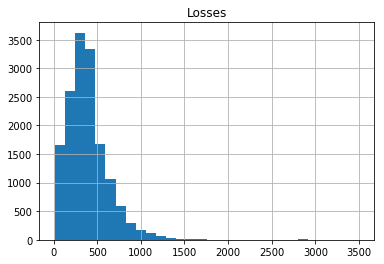

In [6]:
#@title Histogram of Losses
df.hist('Losses', bins=30)

In [7]:
df['Losses'].groupby(df['Married']).describe().append(df['Losses'].groupby(df['Gender']).describe())

,count,mean,std,min,25%,50%,75%,max
Married,7783.0,323.742130,181.687511,13.0,199.0,315.0,404.0,2879.0
Single,7507.0,458.404689,296.103094,15.0,273.0,418.0,583.0,3500.0
F,7747.0,343.711372,202.256914,13.0,208.5,325.0,436.0,3462.0
M,7543.0,437.252685,289.929071,13.0,250.0,391.0,554.0,3500.0


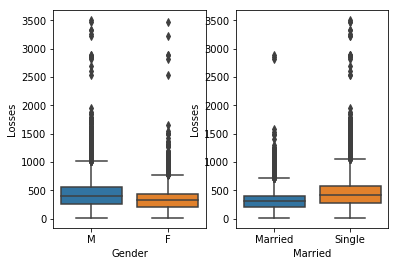

In [8]:
#@title Boxplot with Losses by Gender and by Married
fig, ax =plt.subplots(1,2)
sns.boxplot(df['Gender'],df['Losses'], ax=ax[0])
sns.boxplot(df['Married'], df['Losses'] ,ax=ax[1])
fig.show()

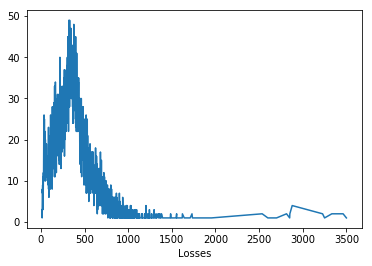

In [136]:
df.groupby(['Losses']).size().plot()
plt.show()

In [10]:
# 0 = P and 1 = D

losses_by_fuel = df[['Fuel Type', 'Losses']].groupby('Fuel Type').sum()
losses_by_fuel['size'] = df.groupby('Fuel Type').size()
losses_by_fuel


,Losses,size
Fuel Type,,
D,2606463,3620
P,3354466,11670


,policy_number,Age,Years of Driving Experience,Number of Vehicles,Gender,Married,Vehicle Age,Fuel Type,Losses
policy_number,1,0.00066,0.0013,0.013,-0.0092,0.0051,-0.0013,0.0024,0.0046
Age,0.00066,1,1,0.0084,0.0054,-0.0043,-0.24,-0.33,-0.44
Years of Driving Experience,0.0013,1,1,0.0085,0.0074,-0.005,-0.24,-0.33,-0.44
Number of Vehicles,0.013,0.0084,0.0085,1,-0.0012,-0.0095,0.0059,-0.0034,-0.012
Gender,-0.0092,0.0054,0.0074,-0.0012,1,-0.008,-0.0035,0.17,0.18
Married,0.0051,-0.0043,-0.005,-0.0095,-0.008,1,-0.0083,-0.22,-0.27
Vehicle Age,-0.0013,-0.24,-0.24,0.0059,-0.0035,-0.0083,1,-0.29,-0.27
Fuel Type,0.0024,-0.33,-0.33,-0.0034,0.17,-0.22,-0.29,1,0.72
Losses,0.0046,-0.44,-0.44,-0.012,0.18,-0.27,-0.27,0.72,1


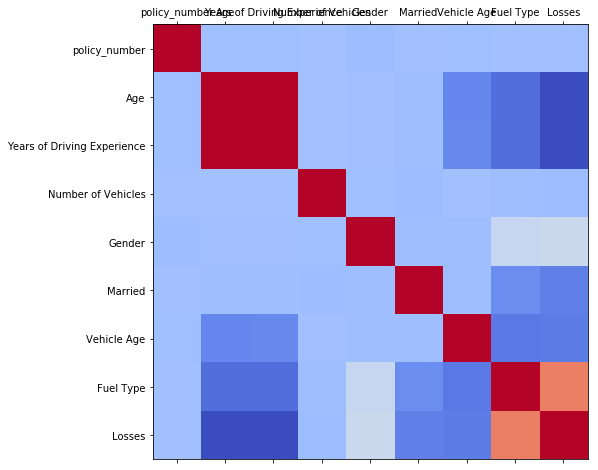

In [139]:
# Replacing non numeric data to 0 and 1 to find correlation between them
df = df.replace('Married', 1).replace('Single', 0).replace('F', 0).replace('M', 1).replace('P', 0).replace('D', 1)
corr = df.corr()
            
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

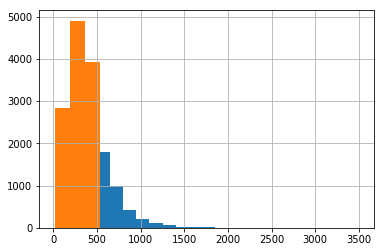

In [163]:
df[df['Fuel Type'] == 1]['Losses'].hist(bins=20)
df[df['Fuel Type'] == 0]['Losses'].hist(bins=20)

On the above cell, we observed a good correlation between Losses and Age/Years of Driving Experience. Besides that, we can see a strong correlation with Fuel Type, but we need to dig deeper to understand if the relationship is about the severity.

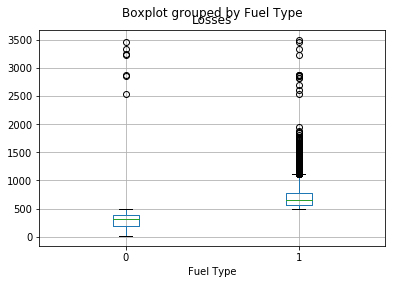

In [162]:
df.boxplot(column=['Losses'], by='Fuel Type')

# Subset Analysis
---
While analyzing the dataset, was realized that exists duplicate policy numbers, therefore needing a more in-depth analysis of a subgroup of clients that had losses with the insurance more than 1 time.


In [13]:
# We have 2244 policy_numbers duplicated in the dataset
df.duplicated(['policy_number'], keep=False).to_frame('duplicated').groupby('duplicated').size()

duplicated
False    13046
True      2244
dtype: int64

In [164]:
# getting the subset of only the duplicated policy_numbers
crashed_df = df[df.duplicated(subset=['policy_number'], keep=False)]
unique_pn_array = crashed_df.policy_number.unique()
crashed_df.head()

,policy_number,Age,Years of Driving Experience,Number of Vehicles,Gender,Married,Vehicle Age,Fuel Type,Losses
5,170545,29,8,1,1,1,9,0,385
10,154593,19,1,1,1,0,12,1,764
19,164235,62,45,1,1,1,0,0,275
24,154647,22,3,1,0,0,11,0,221
33,168484,64,47,1,1,1,5,0,109


In [15]:
# Understand the size of crashes by policy_numbers in the whole dataframe.
df.groupby('policy_number').size().to_frame('size').groupby('size').size().to_frame('Policy Number Amount')

,Policy Number Amount
size,
1,13046
2,1034
3,56
4,2


,policy_number,Age,Years of Driving Experience,Number of Vehicles,Gender,Married,Vehicle Age,Fuel Type,Losses
policy_number,1,-0.02,-0.021,-0.0031,-0.0038,-0.015,0.02,-0.002,-0.0065
Age,-0.02,1,1,-0.0035,-0.016,-0.0068,-0.27,-0.3,-0.41
Years of Driving Experience,-0.021,1,1,-0.0026,-0.017,-0.0067,-0.26,-0.3,-0.41
Number of Vehicles,-0.0031,-0.0035,-0.0026,1,-0.012,-0.013,0.0065,-0.00091,-0.017
Gender,-0.0038,-0.016,-0.017,-0.012,1,-0.037,0.012,0.15,0.19
Married,-0.015,-0.0068,-0.0067,-0.013,-0.037,1,0.00021,-0.22,-0.28
Vehicle Age,0.02,-0.27,-0.26,0.0065,0.012,0.00021,1,-0.3,-0.27
Fuel Type,-0.002,-0.3,-0.3,-0.00091,0.15,-0.22,-0.3,1,0.72
Losses,-0.0065,-0.41,-0.41,-0.017,0.19,-0.28,-0.27,0.72,1


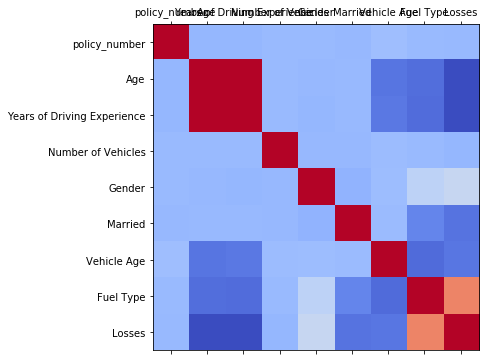

In [16]:
corr = crashed_df.corr()
            
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

[]

<Figure size 432x288 with 0 Axes>

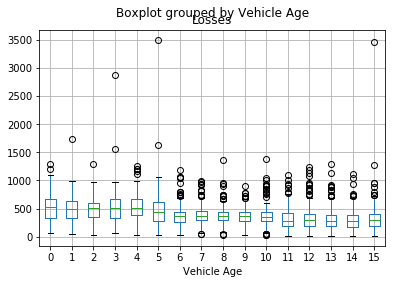

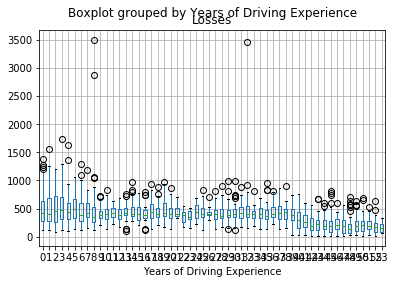

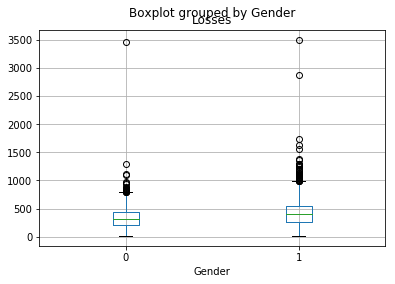

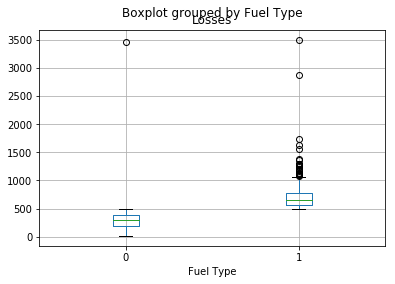

In [166]:
fig = plt.figure()
a = crashed_df.boxplot(column=['Losses'], by='Vehicle Age')
b = crashed_df.boxplot(column=['Losses'], by='Years of Driving Experience')
c = crashed_df.boxplot(column=['Losses'], by='Gender')
d = crashed_df.boxplot(column=['Losses'], by='Fuel Type')

a.plot()
b.plot()
c.plot()
d.plot()

[]

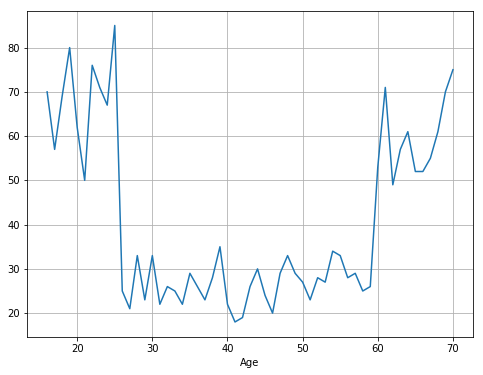

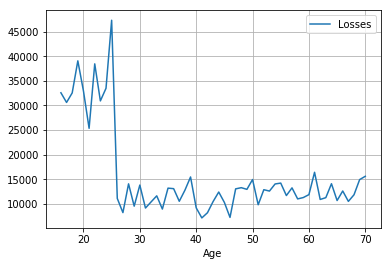

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
a = crashed_df[['Age', 'Losses']].groupby('Age').sum()
b = crashed_df.groupby('Age').size().plot()
plt.grid()
a.plot()
plt.grid()
b.plot()



[]

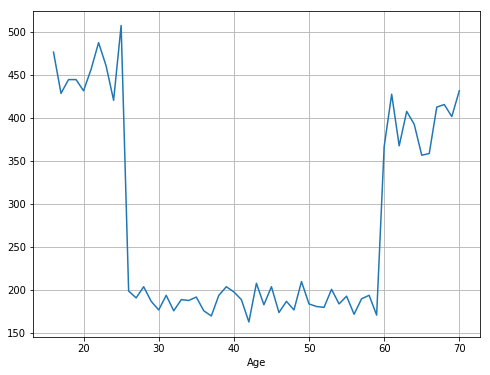

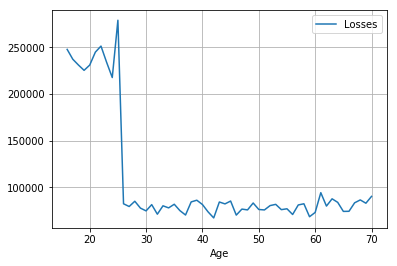

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
a = df[['Age', 'Losses']].groupby('Age').sum()
b = df.groupby('Age').size().plot()
plt.grid()
a.plot()
plt.grid()
b.plot()

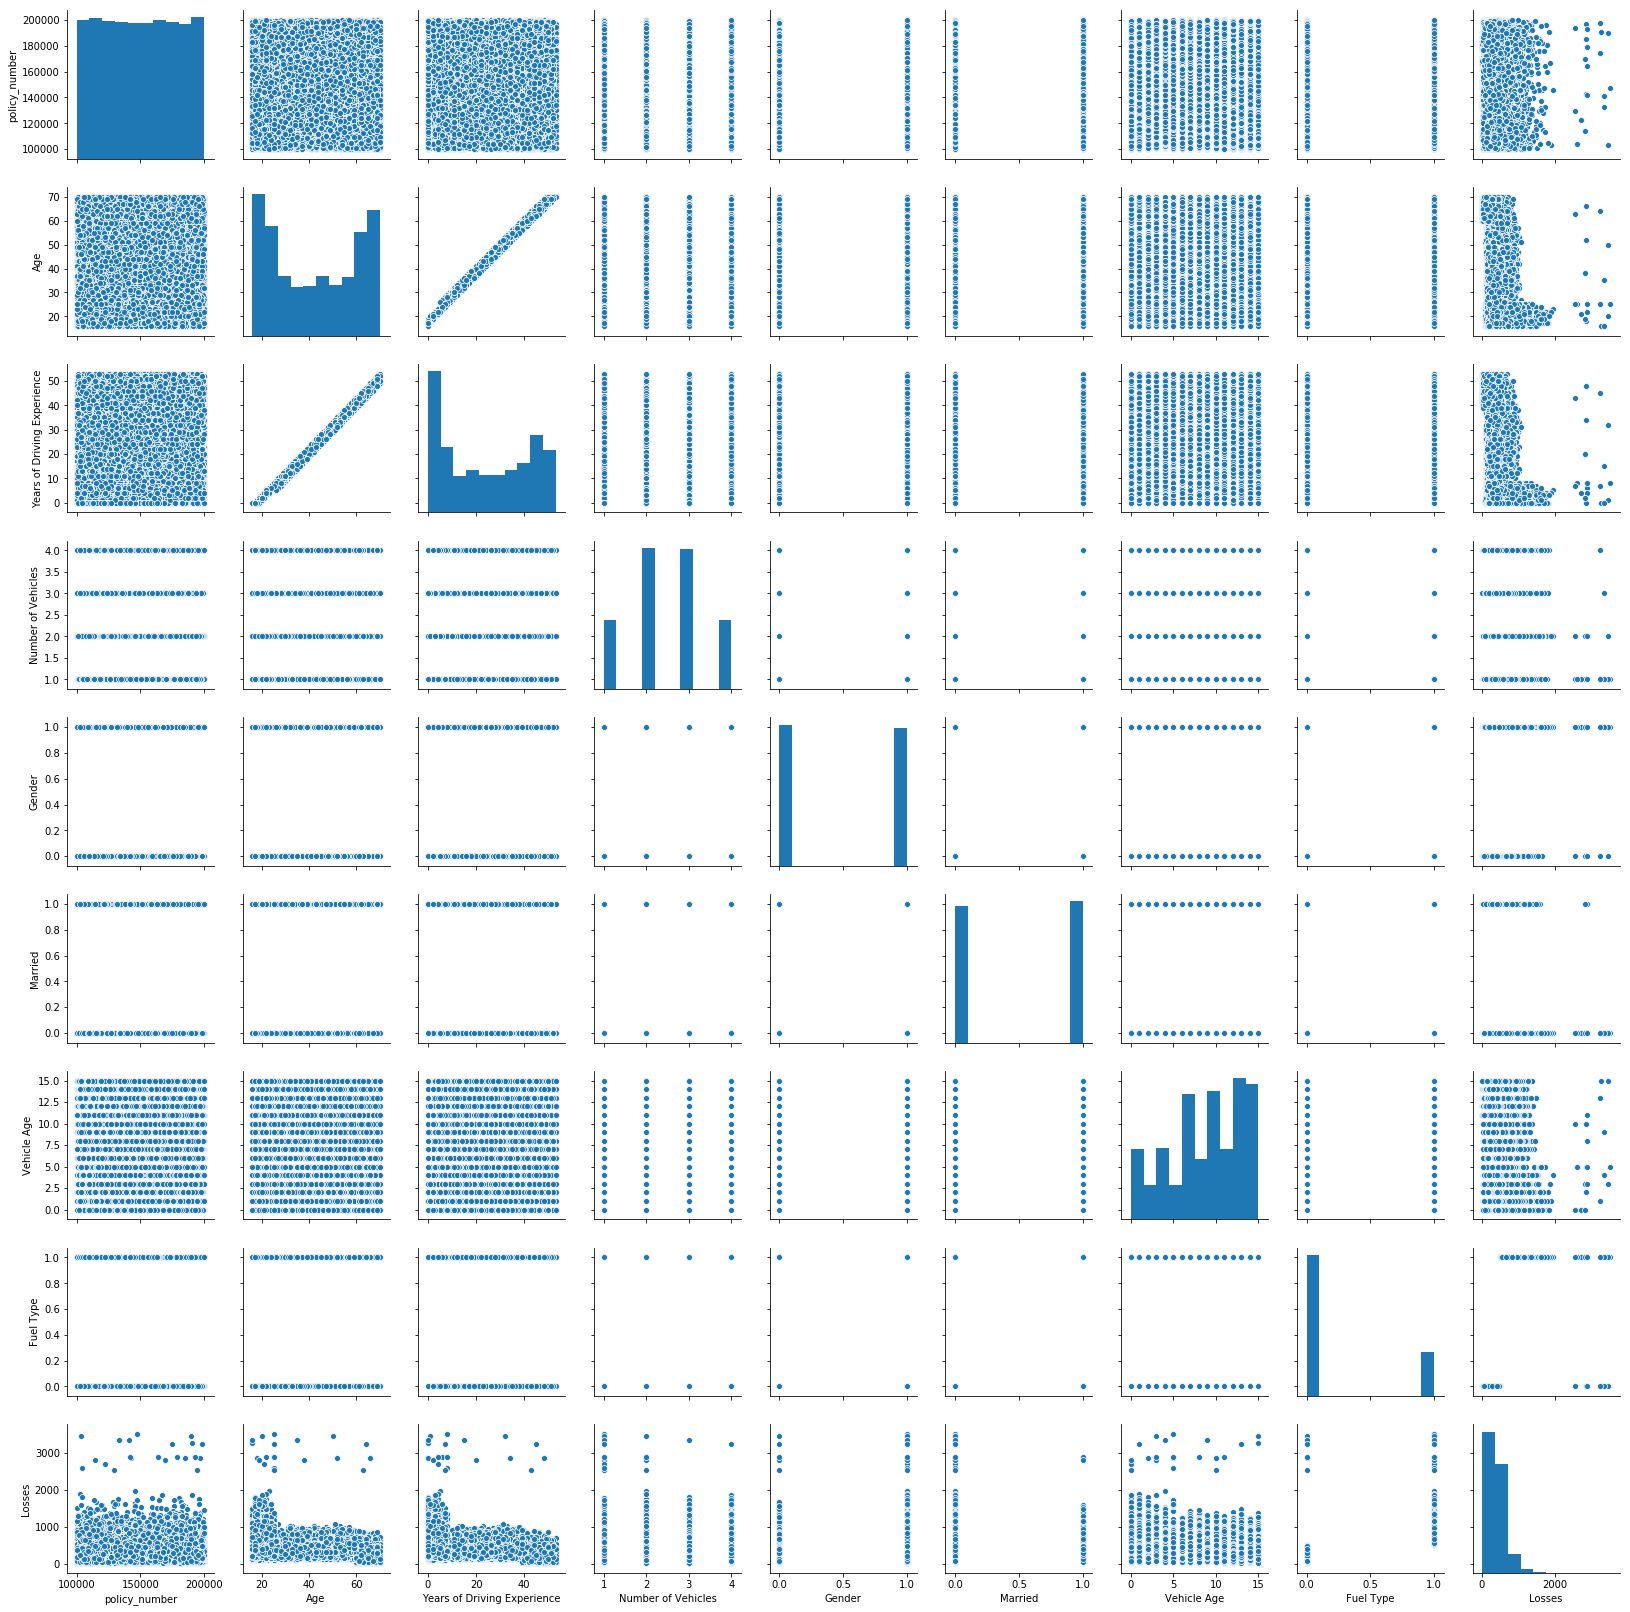

In [27]:
sns.pairplot(df)

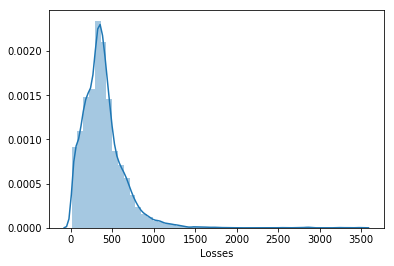

In [28]:
sns.distplot(df['Losses'])

# Applying Linear Regression to the Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Losses   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     3718.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        02:39:18   Log-Likelihood:                -98743.
No. Observations:               15290   AIC:                         1.975e+05
Df Residuals:                   15282   BIC:                         1.976e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         630.8376     18.037     34.974      0.000     595.482     666.193
Age                            -4.1584      0.913     -4.555      0.000      -5.948      -2.369
Years of Driving Experience    -0.4304      0.932     -0.462      0.644      -2.257       1.396
Number of Vehicles             -1.9171      1.309     -1.464      0.143      -4.483       0.649
Vehicle Age                   -12.2334      0.328    -37.300      0.000     -12.876     -11.591
Married                       -79.8463      2.588    -30.852      0.000     -84.919     -74.773
Gender                         51.0959      2.547     20.058      0.000      46.103      56.089
Fuel Type                     301.4239      3.589     83.990      0.000     294.389     308.458
==============================================================================
Omnibus:                    18019.228   Durbin-Watson:                   1.638
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5261258.863
Skew:                           5.889   Prob(JB):                         0.00
Kurtosis:                      93.109   Cond. No.                         798.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

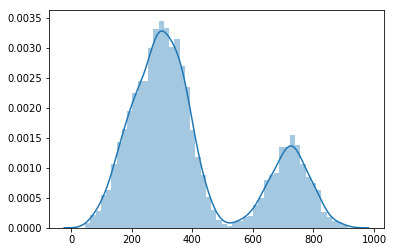

In [303]:
X = df[['Age', 'Years of Driving Experience', 'Number of Vehicles', 'Vehicle Age', 'Married','Gender', 'Fuel Type']]
y = df['Losses']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

import statsmodels.api as sm

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

sns.distplot(model.predict())
model.summary()

In [281]:
lm = LinearRegression()
lm.fit(X_train,y_train)
score = lm.score(X_train,y_train)
print(score)

0.6309156434850287


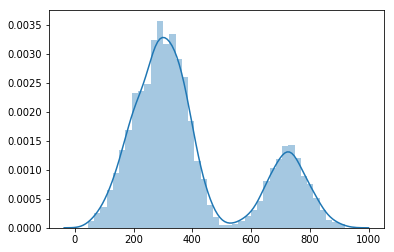

In [286]:
predictions = lm.predict(X_test)

sns.distplot(predictions)


[0.6072110299482749, 0.6531528939881797]


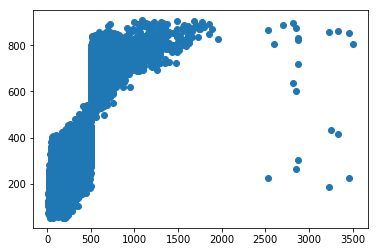

In [238]:
X = pd.DataFrame(df[['Age', 'Vehicle Age', 'Married','Gender', 'Fuel Type']])
y = pd.DataFrame(df[['Losses']])

model = LinearRegression()
scores = []
kfold = KFold(n_splits=2, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)
    if i == 1:
        pred = model.predict(X)
        plt.scatter(y,pred)
print(scores)

In [273]:
from sklearn.metrics import r2_score
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]
r2_score(y_true, y_pred) 

0.9486081370449679

In [0]:
from scipy import stats
cleaned_df = df[(np.abs(stats.zscore(df)) < 4).all(axis=1)]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Losses   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     6575.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        02:56:24   Log-Likelihood:                -94265.
No. Observations:               15221   AIC:                         1.885e+05
Df Residuals:                   15214   BIC:                         1.886e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                602.6985      5.323    113.226      0.000     592.265     613.132
Age                   -4.3014      0.061    -70.857      0.000      -4.420      -4.182
Number of Vehicles     1.1705      1.007      1.162      0.245      -0.804       3.145
Vehicle Age          -11.0076      0.252    -43.661      0.000     -11.502     -10.513
Married              -71.8151      1.990    -36.095      0.000     -75.715     -67.915
Gender                45.7948      1.958     23.386      0.000      41.956      49.633
Fuel Type            294.8308      2.755    107.021      0.000     289.431     300.231
==============================================================================
Omnibus:                     1196.628   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2358.392
Skew:                           0.540   Prob(JB):                         0.00
Kurtosis:                       4.597   Cond. No.                         274.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

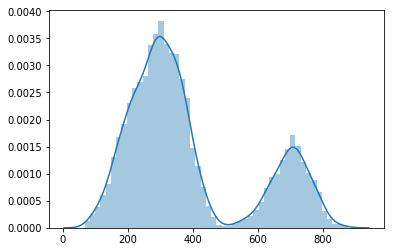

In [351]:
X = cleaned_df[['Age',  'Number of Vehicles', 'Vehicle Age', 'Married','Gender', 'Fuel Type']]
y = cleaned_df['Losses']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

import statsmodels.api as sm

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

sns.distplot(model.predict())
model.summary()

In [348]:
lm = LinearRegression()
lm.fit(X_train,y_train)
score = lm.score(X_train,y_train)
print(score)

0.7208561904652144
